In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn

import time
from pickle import load

import math
import os
from matplotlib.ticker import MultipleLocator
import matplotlib

In [2]:
k = 8
J = 32

# Load data #

## Non climate change data ##

In [24]:
truth_set_f_20 = np.load("../../data/truth_run/f_20_all.npy")

truth_set_f_21 = np.load("../../data/truth_run/climate_change_exp/full_val_21_5_set.npy")[:,:,0] ##21.5


## Climate change ##

In [4]:
truth_set_full  = np.load("../../data/truth_run/climate_change_exp/full_28_set.npy")[:,:,0]


In [5]:

gan_full_f_28 = (np.load("../../data/simulation_runs/gan_gagne/corrected_gans/f_28_all.npy"))

In [6]:

rnn_full_28 =(np.load("../../data/simulation_runs/rnn/rnn_final/f_28_all.npy"))

# X_{k,t} marginal distribution # 

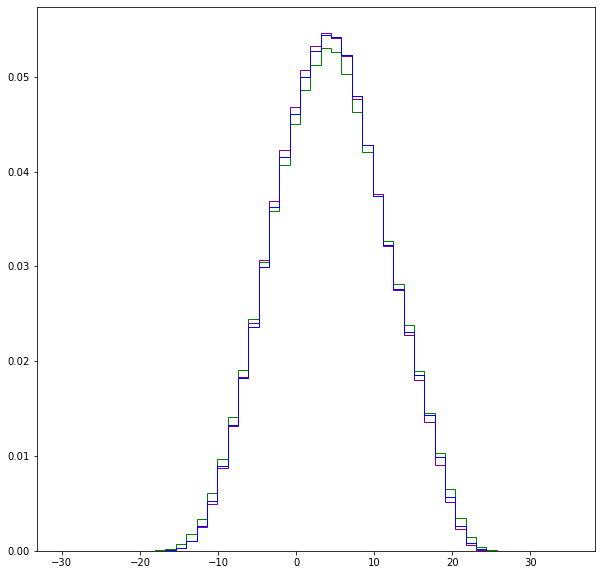

In [7]:
fig,ax = plt.subplots(figsize=(10,10))
bin_seq = np.linspace(-30,35,50)
ax.hist(np.ravel(truth_set_full),bins=bin_seq,histtype="step",density=True,color="green")
ax.hist(np.ravel(gan_full_f_28),bins=bin_seq,histtype="step",color="purple",density=True)
ax.hist(np.ravel(rnn_full_28),bins=bin_seq,histtype="step",color="blue",density=True)

plt.show()

In [15]:
fig,ax = plt.subplots(figsize=(10,10))
bin_seq = np.linspace(-30,35,50)
truth,_,_ = ax.hist(np.ravel(truth_set_full),bins=bin_seq,histtype="step",density=True,color="green")
gan,_,_ = ax.hist(np.ravel(gan_full_f_28),bins=bin_seq,histtype="step",color="purple",density=True)
rnn,_,_ = ax.hist(np.ravel(rnn_full_28),bins=bin_seq,histtype="step",color="blue",density=True)

plt.close()

In [16]:
#deal with numerical stuff due to y_true containing zero
truth = truth + 1e-10
rnn = rnn + 1e-10
gan = gan + 1e-10



In [53]:
#kl between rnn and true
np.sum(np.log(truth/rnn)*truth)


0.0015096053431956473

In [54]:
#kl between gan and true
np.sum(np.log(truth/gan)*truth)


0.00245260195234201

# Principal Component analysis #

In [7]:
#PCA / EOF analysis
from sklearn.decomposition import PCA

In [8]:
#smoothing data temporally
from scipy.ndimage import uniform_filter1d

In [9]:
smoothed_data = uniform_filter1d(truth_set_full,size=80,axis=0)

In [26]:
smoothed_data_f_20 = uniform_filter1d(truth_set_f_20,size=80,axis=0)
smoothed_data_f_21 = uniform_filter1d(truth_set_f_21,size=80,axis=0)

In [11]:
pca_smooth = PCA(n_components=4)

In [12]:
pca_data_smooth_f_20 = pca_smooth.fit_transform(smoothed_data_f_20) #get the original pca components

In [27]:
pca_data_smooth_f_21 = pca_smooth.transform(smoothed_data_f_21) #get the original pca components

In [13]:
pca_data_smooth_f_28 = pca_smooth.transform(smoothed_data) #for the f 28 test data

In [28]:
dim1 = (pca_data_smooth_f_28[:,0]**2 + pca_data_smooth_f_28[:,1]**2)**0.5
dim2 = (pca_data_smooth_f_28[:,2]**2 + pca_data_smooth_f_28[:,3]**2)**0.5
dim1_f21 = (pca_data_smooth_f_21[:,0]**2 + pca_data_smooth_f_21[:,1]**2)**0.5
dim2_f21 = (pca_data_smooth_f_21[:,2]**2 + pca_data_smooth_f_21[:,3]**2)**0.5

In [29]:
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1)]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [30]:
discretized_jet = cmap_discretize(matplotlib.cm.turbo, 20)


In [31]:
discretized_mono = cmap_discretize(matplotlib.cm.binary, 20)
discretized_div = cmap_discretize(matplotlib.cm.RdBu, 20)

In [36]:
density,xedges,yedges,d = plt.hist2d(x=dim1,y=dim2,bins=100,cmap=discretized_jet,density=True,vmax=0.04,range=[[0,15],[0,10]])
density_21,xedges,yedges,d = plt.hist2d(x=dim1_f21,y=dim2_f21,bins=100,cmap=discretized_jet,density=True,vmax=0.04,range=[[0,15],[0,10]])
plt.close()

In [37]:
X,Y=np.meshgrid(xedges,yedges)

In [38]:
diff_density = density.T - density_21.T

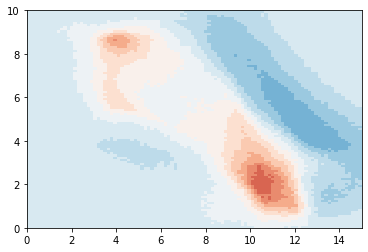

In [39]:
#this is the plot

plt.pcolormesh(X,Y,diff_density,cmap=discretized_div,vmin=-0.05,vmax=0.04)


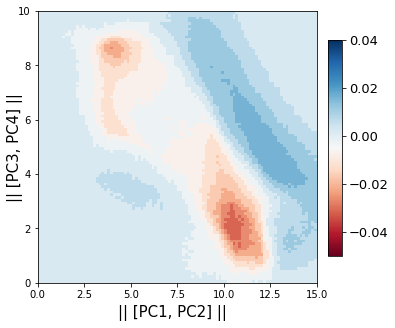

In [40]:
#recreating fig 7b / 8a
fig,ax = plt.subplots(figsize=(5,5))
plt.rcParams['font.size'] = '13'

ax.pcolormesh(X,Y,diff_density,cmap=discretized_div,vmin=-0.05,vmax=0.04)
#ax.text(-0.1,10.7,"(a) Truth",fontsize=15,va="top")


norm = matplotlib.colors.Normalize(vmin=-0.05,vmax=0.04)
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
cax = fig.add_axes([0.93,0.2,0.04,0.6])
fig.colorbar(sm, ticks=[-0.04,-0.02,0,0.02,0.04],cax=cax)

fig.text(0.5, 0.03, '|| [PC1, PC2] ||', ha='center', fontsize="15")
fig.text(0.04, 0.5, '|| [PC3, PC4] ||', va='center', rotation='vertical',fontsize="15")

# plt.savefig("clim_change_diff.pdf",bbox_inches="tight")


plt.show()

### Comparing across models ###

In [24]:
# #poly (with already trained pca components)
# smoothed_data_poly_f_23 = uniform_filter1d(polynomial_data[:,:],size=80,axis=0)
# smoothed_data_poly_f_20 = uniform_filter1d(polynomial_data_f_20[:,:],size=80,axis=0)

# pca_data_poly_20 = pca_smooth.transform(smoothed_data_poly_f_20)
# pca_data_poly_23 = pca_smooth.transform(smoothed_data_poly_f_23)


# dim1_poly_20 = (pca_data_poly_20[:,0]**2 + pca_data_poly_20[:,1]**2)**0.5
# dim2_poly_20 = (pca_data_poly_20[:,2]**2 + pca_data_poly_20[:,3]**2)**0.5

# dim1_poly_23 = (pca_data_poly_23[:,0]**2 + pca_data_poly_23[:,1]**2)**0.5
# dim2_poly_23 = (pca_data_poly_23[:,2]**2 + pca_data_poly_23[:,3]**2)**0.5

# density_23_poly,xedges,yedges,d = plt.hist2d(x=dim1_poly_23,y=dim2_poly_23,bins=100,cmap=discretized_jet,density=True,vmax=0.04,range=[[0,15],[0,10]])
# density_20_poly,xedges,yedges,d = plt.hist2d(x=dim1_poly_20,y=dim2_poly_20,bins=100,cmap=discretized_jet,density=True,vmax=0.04,range=[[0,15],[0,10]])
# plt.close()

# diff_density_poly = density_23_poly.T - density_20_poly.T


# plt.pcolormesh(X,Y,diff_density_poly,cmap=discretized_jet,vmin=-0.05,vmax=0.04)


In [41]:
#rnn
smoothed_data_rnn_f_28 = uniform_filter1d(rnn_full_28[:,:],size=80,axis=0)

pca_data_smooth_rnn_28 = pca_smooth.transform(smoothed_data_rnn_f_28)

dim1_rnn_28 = (pca_data_smooth_rnn_28[:,0]**2 + pca_data_smooth_rnn_28[:,1]**2)**0.5
dim2_rnn_28 = (pca_data_smooth_rnn_28[:,2]**2 + pca_data_smooth_rnn_28[:,3]**2)**0.5

In [42]:
density_28_rnn,xedges,yedges,d = plt.hist2d(x=dim1_rnn_28,y=dim2_rnn_28,bins=100,cmap=discretized_jet,density=True,vmax=0.04,range=[[0,15],[0,10]])
plt.close()

In [43]:
#gan (with already trained pca components)

smoothed_data_gan_f_28 = uniform_filter1d(gan_full_f_28[:,:],size=80,axis=0)

pca_data_gan_28 = pca_smooth.transform(smoothed_data_gan_f_28)

dim1_gan_28 = (pca_data_gan_28[:,0]**2 + pca_data_gan_28[:,1]**2)**0.5
dim2_gan_28 = (pca_data_gan_28[:,2]**2 + pca_data_gan_28[:,3]**2)**0.5

In [44]:
density_28_gan,xedges,yedges,d = plt.hist2d(x=dim1_gan_28,y=dim2_gan_28,bins=100,cmap=discretized_jet,density=True,vmax=0.04,range=[[0,15],[0,10]])
plt.close()

In [45]:
density_gan_kl = density_28_gan+ 1e-10
density_rnn_kl = density_28_rnn+ 1e-10
density_true_kl = density+ 1e-10


In [46]:
#kl between rnn and true
np.sum(np.log(density_true_kl/density_rnn_kl)*density_true_kl)


0.578930142221426

In [47]:
#kl between gan and true
np.sum(np.log(density_true_kl/density_gan_kl)*density_true_kl)


0.7122701435759689

In [48]:
import matplotlib as mpl


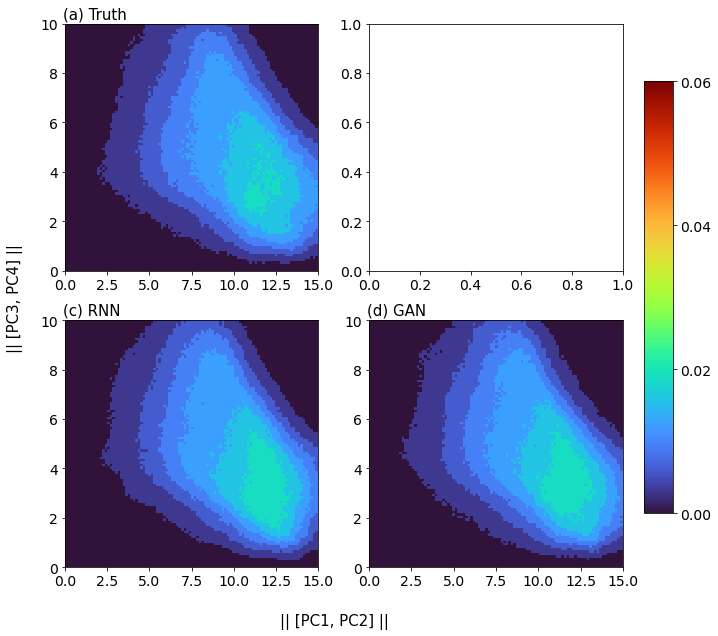

In [50]:
#recreating fig 7b / 8a
fig,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=2)

plt.rcParams['font.size'] = '14'

ax[0,0].hist2d(x=dim1,y=dim2,bins=100,cmap=discretized_jet,density=True,vmax=0.06,range=[[0,15],[0,10]])
ax[0,0].text(-0.1,10.7,"(a) Truth",fontsize=15,va="top")

# ax[0,1].hist2d(x=dim1_poly_23,y=dim2_poly_23,bins=100,cmap=discretized_jet,density=True,vmax=0.06,range=[[0,15],[0,10]])
# ax[0,1].text(-0.1,10.7,"(b) Polynomial",fontsize=15,va="top")


ax[1,0].hist2d(x=dim1_rnn_28,y=dim2_rnn_28,bins=100,cmap=discretized_jet,density=True,vmax=0.06,range=[[0,15],[0,10]])
ax[1,0].text(-0.1,10.7,"(c) RNN",fontsize=15,va="top")


ax[1,1].hist2d(x=dim1_gan_28,y=dim2_gan_28,bins=100,cmap=discretized_jet,density=True,vmax=0.06,range=[[0,15],[0,10]])
ax[1,1].text(-0.1,10.7,"(d) GAN",fontsize=15,va="top")



norm = mpl.colors.Normalize(vmin=0,vmax=0.06)
sm = plt.cm.ScalarMappable(cmap="turbo", norm=norm)
sm.set_array([])
cax = fig.add_axes([0.93,0.2,0.04,0.6])
fig.colorbar(sm, ticks=[0,0.02,0.04,0.06,0.08],cax=cax)

fig.text(0.5, 0.045, '|| [PC1, PC2] ||', ha='center', fontsize="15")
fig.text(0.045, 0.5, '|| [PC3, PC4] ||', va='center', rotation='vertical',fontsize="15")

# plt.savefig("regime_plots_clim_change.pdf",bbox_inches="tight")


plt.show()

In [51]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0],[0],color="#4daf4a",lw=4,label="Truth"),
                    
                  Line2D([0],[0],color="#377eb8",lw=2,label="RNN"),
                  Line2D([0],[0],color="#984ea3",lw=2,label="GAN")]

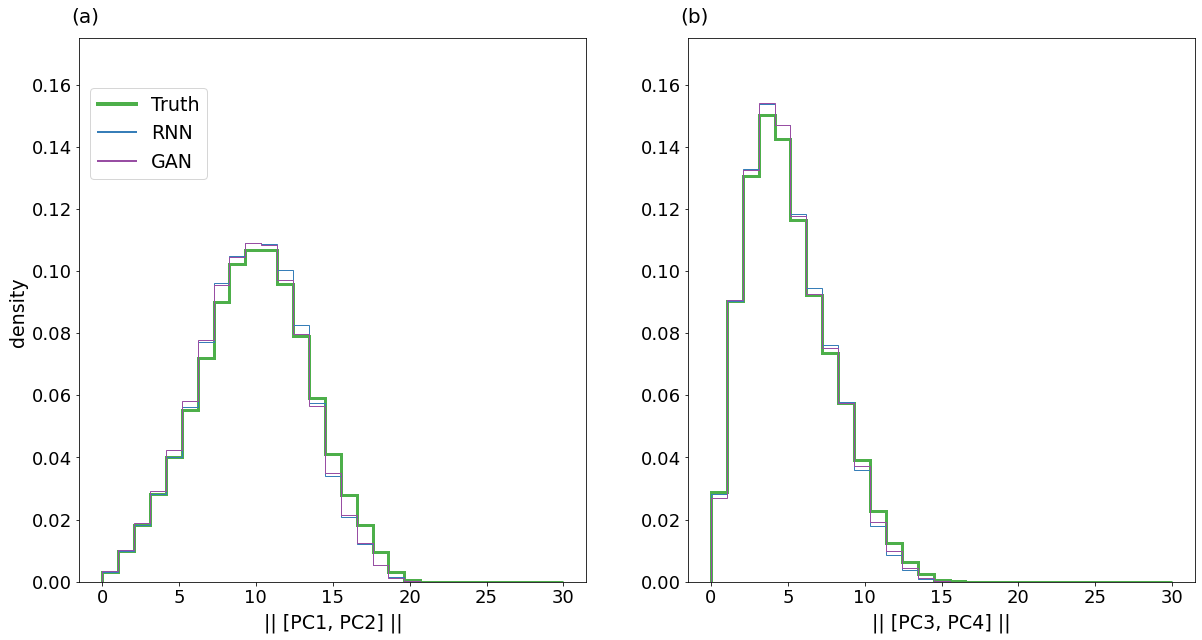

In [53]:
#joint figure of two regimes

bin_seq = np.linspace(0,30,30)
bin_seq2 = np.linspace(0,30,30)

plt.rcParams['font.size'] = '18'

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))

ax[0].hist(np.ravel(dim1),bins=bin_seq,color="#4daf4a",density=True,histtype="step",linewidth=3)
ax[0].hist(np.ravel(dim1_rnn_28[:]),bins=bin_seq,color="#377eb8",density=True,histtype="step")
ax[0].hist(np.ravel(dim1_gan_28[:]),bins=bin_seq,color="#984ea3",density=True,histtype="step")

ax[1].hist(np.ravel(dim2[:]),bins=bin_seq2,color="#4daf4a",density=True,histtype="step",linewidth=3)
ax[1].hist(np.ravel(dim2_rnn_28[:]),bins=bin_seq2,color="#377eb8",density=True,histtype="step")
ax[1].hist(np.ravel(dim2_gan_28[:]),bins=bin_seq2,color="#984ea3",density=True,histtype="step")



ax[0].text(15, -0.015, '|| [PC1, PC2] ||', ha='center', fontsize="19")
ax[1].text(15, -0.015, '|| [PC3, PC4] ||', ha='center', fontsize="19")

ax[0].text(-2,0.185,"(a)",fontsize=20,va="top")
ax[1].text(-2,0.185,"(b)",fontsize=20,va="top")

fig.legend(handles=legend_elements,loc=(0.075,0.72),prop={"size":19})

fig.text(0.076, 0.5, 'density', va='center', rotation='vertical',fontsize="19")

# ax[0].set_xlim([0,20])
ax[0].set_ylim([0,0.175])

# ax[1].set_xlim([0,13])
ax[1].set_ylim([0,0.175])

# plt.savefig("clim_change_regime_hists.pdf",bbox_inches="tight")




plt.show()

In [54]:
fig,ax = plt.subplots()
bin_seq = np.linspace(0,22,30)

y_true,_,_ = ax.hist(np.ravel(dim1),bins=bin_seq,color="grey",density=True,histtype="step")
y_rnn,_,_ = ax.hist(np.ravel(dim1_rnn_28),bins=bin_seq,color="blue",density=True,histtype="step")
y_gan,_,_ = ax.hist(np.ravel(dim1_gan_28),bins=bin_seq,color="purple",density=True,histtype="step")
plt.close()


In [55]:
#deal with numerical stuff due to y_true containing zero
y_true = y_true + 1e-10
y_rnn = y_rnn + 1e-10
y_gan = y_gan + 1e-10



In [56]:
#kl between rnn and true
np.sum(np.log(y_true/y_rnn)*y_true)


0.007945549419230096

In [57]:
#kl between gan and true
np.sum(np.log(y_true/y_gan)*y_true)



0.008655001673121774

In [59]:
fig,ax = plt.subplots()
bin_seq2 = np.linspace(0,20,30)


y_true2,_,_ = ax.hist(np.ravel(dim2),bins=bin_seq2,color="grey",density=True,histtype="step")
y_rnn2,_,_ = ax.hist(np.ravel(dim2_rnn_28),bins=bin_seq2,color="blue",density=True,histtype="step")
y_gan2,_,_ = ax.hist(np.ravel(dim2_gan_28),bins=bin_seq2,color="blue",density=True,histtype="step")

plt.close()

In [60]:
#deal with numerical stuff due to y_true containing zero
y_true2 = y_true2 + 1e-10
y_rnn2 = y_rnn2 + 1e-10
y_gan2= y_gan2 + 1e-10

In [61]:
#kl between rnn and true
np.sum(np.log(y_true2/y_rnn2)*y_true2)


0.005562571001021655

In [62]:
#kl between gan and true
np.sum(np.log(y_true2/y_gan2)*y_true2)


0.0038167633698695017